In [1]:
import hail as hl
hl.init()

Loading BokehJS ...

24/06/07 15:01:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.4
SparkUI available at http://bens-air.dfci.harvard.edu:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130-bea04d9c79b5
LOGGING: writing to /Users/benoppenheimer/Dropbox (Partners HealthCare)/ancestry_analysis_2/code/hail-20240607-1501-0.2.130-bea04d9c79b5.log


In [2]:
import onnx
from gnomad.sample_qc.ancestry import apply_onnx_classification_model, assign_population_pcs
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import show
from bokeh.layouts import gridplot

get ancestry assignments

In [3]:
gnomad_v4_onnx_rf = "../RF_gnomad_models/gnomad.v4.0.RF_fit.onnx"
with hl.hadoop_open(gnomad_v4_onnx_rf, "rb") as f:
    v4_onx_fit = onnx.load(f)

In [4]:
v4_num_pcs = 20
v4_min_prob = 0.75

In [18]:
v4_pcs_ht = hl.import_table("../gnomad_pca_projections/v4_pcs_ht.tsv", key="s", types = {"scores": hl.dtype('array<float>')})
v4_pcs_ht.show()

2024-06-04 21:39:44.833 Hail: INFO: Reading table without type imputation
  Loading field 's' as type str (not specified)
  Loading field 'scores' as type array<float64> (user-supplied)


,
s,scores
str,array<float64>
"""CW-170-S""","[-1.03e-03,1.04e-04,1.05e-02,1.09e-01,1.82e-02,-1.13e-03,-7.09e-03,-3.68e-03,6.13e-03,8.42e-03,-2.05e-03,-3.72e-04,9.93e-04,1.09e-03,6.33e-04,3.03e-04,-1.10e-03,-1.44e-03,-2.60e-03,-2.46e-03,4.38e-04,-1.14e-03,1.62e-03,-1.69e-03,-9.13e-04,4.33e-03,-1.53e-03,-1.66e-03,3.14e-03,2.61e-04]"
"""CW-179-S""","[2.16e-03,2.80e-03,-2.35e-03,-3.59e-03,-4.38e-03,1.74e-04,-1.55e-03,-5.45e-04,1.85e-03,2.24e-03,-2.24e-03,-7.86e-04,3.82e-04,-2.36e-03,1.62e-03,-4.37e-04,2.75e-03,7.56e-05,6.39e-05,1.37e-03,-2.92e-04,2.14e-04,7.50e-04,3.81e-04,4.65e-04,-6.28e-04,2.43e-03,-1.11e-03,-3.45e-03,1.52e-03]"
"""CW117-S""","[-1.81e-04,-1.10e-03,1.11e-02,1.21e-01,2.17e-02,9.10e-06,-9.02e-03,-5.20e-03,8.20e-03,9.99e-03,1.49e-05,2.49e-04,-9.47e-04,-5.66e-03,2.52e-03,-4.63e-04,-3.18e-03,7.18e-04,-2.65e-03,-1.64e-03,1.94e-04,-4.67e-04,2.58e-03,-3.54e-05,3.04e-03,-2.26e-03,1.65e-03,-7.16e-04,-1.15e-03,-1.44e-03]"
"""CW12S""","[-5.76e-04,6.06e-04,1.01e-02,1.06e-01,1.65e-02,-1.41e-03,-6.43e-03,-3.07e-03,8.35e-03,1.03e-02,-1.08e-03,6.97e-04,-3.79e-03,1.85e-03,1.30e-03,5.65e-05,-2.12e-03,-7.37e-04,5.66e-04,-2.74e-03,1.52e-03,-1.12e-03,-2.76e-05,-3.19e-03,2.69e-03,7.43e-04,-1.38e-03,4.98e-04,-2.66e-03,-1.74e-04]"
"""CW140-G""","[-6.00e-04,-1.16e-03,7.57e-03,6.94e-03,-1.19e-03,-7.55e-05,2.80e-03,5.74e-03,-1.29e-02,-1.72e-02,-1.97e-03,-1.28e-03,6.32e-03,-1.27e-04,-9.13e-03,2.65e-03,1.03e-02,-2.50e-03,7.13e-03,8.51e-05,-8.78e-04,2.08e-04,-5.65e-03,-1.48e-04,2.10e-03,-8.17e-04,5.95e-03,-1.32e-03,-2.47e-04,-2.23e-03]"
"""CW215-S""","[-2.07e-03,1.18e-03,9.70e-03,9.75e-02,1.72e-02,-1.19e-03,-7.14e-03,-2.27e-03,3.48e-03,4.42e-03,-1.22e-03,6.57e-04,-1.12e-03,1.77e-03,3.00e-03,-5.89e-04,-2.48e-03,8.43e-04,-1.31e-04,1.12e-03,1.66e-03,-5.06e-04,1.78e-03,8.00e-04,-2.86e-03,2.66e-04,7.77e-04,6.38e-05,2.83e-04,-2.48e-03]"
"""CW226-S""","[1.88e-03,2.68e-03,-2.64e-03,-1.36e-03,-2.25e-03,6.04e-05,6.25e-05,8.60e-04,-1.08e-03,-1.67e-03,4.96e-04,-7.43e-04,4.78e-04,2.56e-04,-8.31e-04,6.77e-04,2.14e-03,-5.29e-04,5.31e-04,-6.65e-05,-6.93e-04,6.55e-05,-7.25e-04,1.27e-03,-7.44e-04,-1.12e-03,3.10e-03,-2.21e-04,-2.89e-03,-7.89e-04]"
"""CW232-S""","[-2.75e-04,1.99e-03,3.36e-03,2.60e-03,-1.04e-03,3.04e-04,-4.57e-04,4.37e-03,-8.37e-03,-1.17e-02,-3.24e-03,-2.62e-04,5.45e-03,-8.97e-04,-6.03e-03,1.83e-03,4.82e-03,-1.68e-03,5.72e-03,-1.14e-03,-4.44e-04,-5.72e-04,-2.89e-03,-1.63e-03,2.40e-03,1.60e-03,4.84e-03,-1.67e-03,-7.68e-03,2.16e-03]"


In [19]:
v4_results_ht, v3_model = assign_population_pcs(
    v4_pcs_ht,
    pc_cols=v4_pcs_ht.scores[:v4_num_pcs],
    fit=v4_onx_fit,
    min_prob=0.3,
    apply_model_func = apply_onnx_classification_model
)

2024-06-04 21:39:46.589 Hail: INFO: Coerced sorted dataset
INFO (gnomad.sample_qc.ancestry 369): Found the following sample count after population assignment: asj: 71, nfe: 252, mid: 8, amr: 3, sas: 1, afr: 1


In [20]:
v4_results_ht.show()

,,,,,,,,,,,
s,pca_scores,pop,prob_afr,prob_ami,prob_amr,prob_asj,prob_eas,prob_fin,prob_mid,prob_nfe,prob_sas
str,array<float64>,str,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""CW-170-S""","[-1.03e-03,1.04e-04,1.05e-02,1.09e-01,1.82e-02,-1.13e-03,-7.09e-03,-3.68e-03,6.13e-03,8.42e-03,-2.05e-03,-3.72e-04,9.93e-04,1.09e-03,6.33e-04,3.03e-04,-1.10e-03,-1.44e-03,-2.60e-03,-2.46e-03]","""asj""",2.00e-02,0.00e+00,3.00e-02,8.50e-01,2.00e-02,0.00e+00,3.00e-02,4.00e-02,1.00e-02
"""CW-179-S""","[2.16e-03,2.80e-03,-2.35e-03,-3.59e-03,-4.38e-03,1.74e-04,-1.55e-03,-5.45e-04,1.85e-03,2.24e-03,-2.24e-03,-7.86e-04,3.82e-04,-2.36e-03,1.62e-03,-4.37e-04,2.75e-03,7.56e-05,6.39e-05,1.37e-03]","""nfe""",1.40e-01,0.00e+00,2.30e-01,3.00e-02,4.00e-02,5.00e-02,0.00e+00,5.00e-01,1.00e-02
"""CW117-S""","[-1.81e-04,-1.10e-03,1.11e-02,1.21e-01,2.17e-02,9.10e-06,-9.02e-03,-5.20e-03,8.20e-03,9.99e-03,1.49e-05,2.49e-04,-9.47e-04,-5.66e-03,2.52e-03,-4.63e-04,-3.18e-03,7.18e-04,-2.65e-03,-1.64e-03]","""asj""",2.00e-02,0.00e+00,3.00e-02,8.60e-01,2.00e-02,0.00e+00,1.00e-02,5.00e-02,1.00e-02
"""CW12S""","[-5.76e-04,6.06e-04,1.01e-02,1.06e-01,1.65e-02,-1.41e-03,-6.43e-03,-3.07e-03,8.35e-03,1.03e-02,-1.08e-03,6.97e-04,-3.79e-03,1.85e-03,1.30e-03,5.65e-05,-2.12e-03,-7.37e-04,5.66e-04,-2.74e-03]","""asj""",4.00e-02,0.00e+00,5.00e-02,8.00e-01,2.00e-02,0.00e+00,2.00e-02,6.00e-02,1.00e-02
"""CW140-G""","[-6.00e-04,-1.16e-03,7.57e-03,6.94e-03,-1.19e-03,-7.55e-05,2.80e-03,5.74e-03,-1.29e-02,-1.72e-02,-1.97e-03,-1.28e-03,6.32e-03,-1.27e-04,-9.13e-03,2.65e-03,1.03e-02,-2.50e-03,7.13e-03,8.51e-05]","""nfe""",3.00e-02,0.00e+00,2.10e-01,0.00e+00,2.00e-02,1.00e-02,9.00e-02,6.20e-01,2.00e-02
"""CW215-S""","[-2.07e-03,1.18e-03,9.70e-03,9.75e-02,1.72e-02,-1.19e-03,-7.14e-03,-2.27e-03,3.48e-03,4.42e-03,-1.22e-03,6.57e-04,-1.12e-03,1.77e-03,3.00e-03,-5.89e-04,-2.48e-03,8.43e-04,-1.31e-04,1.12e-03]","""asj""",8.00e-02,0.00e+00,7.00e-02,6.20e-01,1.00e-02,1.00e-02,3.00e-02,1.70e-01,1.00e-02
"""CW226-S""","[1.88e-03,2.68e-03,-2.64e-03,-1.36e-03,-2.25e-03,6.04e-05,6.25e-05,8.60e-04,-1.08e-03,-1.67e-03,4.96e-04,-7.43e-04,4.78e-04,2.56e-04,-8.31e-04,6.77e-04,2.14e-03,-5.29e-04,5.31e-04,-6.65e-05]","""nfe""",8.00e-02,0.00e+00,2.40e-01,5.00e-02,3.00e-02,4.00e-02,1.00e-02,5.20e-01,3.00e-02
"""CW232-S""","[-2.75e-04,1.99e-03,3.36e-03,2.60e-03,-1.04e-03,3.04e-04,-4.57e-04,4.37e-03,-8.37e-03,-1.17e-02,-3.24e-03,-2.62e-04,5.45e-03,-8.97e-04,-6.03e-03,1.83e-03,4.82e-03,-1.68e-03,5.72e-03,-1.14e-03]","""nfe""",8.00e-02,0.00e+00,2.80e-01,1.00e-02,0.00e+00,3.00e-02,5.00e-02,5.30e-01,2.00e-02


In [28]:
samples_of_interest = {"DFCI-154P-C", "DFCI-568R-C", "DFCI-166P-C"}
samples_of_interest = hl.literal(samples_of_interest)
v4_results_ht.filter(samples_of_interest.contains(v4_results_ht["s"])).to_pandas().drop(columns="pca_scores")

2024-06-04 21:48:16.328 Hail: INFO: Coerced sorted dataset


,s,pop,prob_afr,prob_ami,prob_amr,prob_asj,prob_eas,prob_fin,prob_mid,prob_nfe,prob_sas
0,DFCI-154P-C,nfe,0.1,0.0,0.18,0.19,0.02,0.02,0.07,0.36,0.06
1,DFCI-166P-C,amr,0.06,0.01,0.69,0.0,0.01,0.01,0.0,0.22,0.0
2,DFCI-568R-C,nfe,0.08,0.0,0.13,0.32,0.05,0.02,0.03,0.36,0.01


In [12]:
v4_results_df = pd.read_csv("../gnomad_pca_projections/v4_pcs_ht_copy_gnomad_workflow.tsv", sep="\t", index_col=0)
v4_results_df.loc[:, "scores"] = v4_results_df.scores.apply(lambda x: [float(y) for y in x.strip("[]").split(",")])
v4_results_df.head()

,scores
s,
CW-170-S,"[-0.0010380223871799877, 0.0001377195826216701..."
CW-179-S,"[0.002238793419696749, 0.002975466848851369, -..."
CW117-S,"[-3.94738718905708e-05, -0.0009828106156535468..."
CW12S,"[-0.0005161591734873076, 0.0005947731833153549..."
CW140-G,"[-0.0007476901299114795, -0.000957266271829790..."


In [13]:
v4_results_df.loc[:, "scores"] = v4_results_df.scores.apply(lambda x: x[0:20])
len(v4_results_df.scores.iloc[0])

20

In [14]:
pc_cols = ["PC" + str(i) for i in range(1,21)]
v4_results_df = pd.DataFrame(v4_results_df.scores.to_list(), index=v4_results_df.index, columns=pc_cols)
#v4_results_df["Ancestry Assigned by Gnomad"] = v4_results_ht["pop"].collect()
v4_results_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
s,,,,,,,,,,,,,,,,,,,,
CW-170-S,-0.001038,0.000138,0.010739,0.112265,0.018732,-0.001194,-0.007350,-0.003840,0.006583,0.009050,-0.002030,-0.000325,0.000783,0.001149,0.000815,0.000265,-0.001271,-0.001679,-0.002769,-0.002365
CW-179-S,0.002239,0.002975,-0.002483,-0.003688,-0.004554,0.000150,-0.001801,-0.000568,0.001934,0.002351,-0.002275,-0.000784,0.000342,-0.002312,0.001698,-0.000438,0.002681,0.000119,0.000047,0.001374
CW117-S,-0.000039,-0.000983,0.011564,0.126369,0.022557,-0.000032,-0.009366,-0.005493,0.008727,0.010807,-0.000169,0.000431,-0.001113,-0.005610,0.002871,-0.000558,-0.002894,0.001097,-0.002559,-0.001626
CW12S,-0.000516,0.000595,0.010090,0.105611,0.016352,-0.001376,-0.006102,-0.002999,0.008146,0.010044,-0.000979,0.000651,-0.003676,0.001627,0.001280,0.000123,-0.001820,-0.000494,0.000462,-0.002822
CW140-G,-0.000748,-0.000957,0.007738,0.007100,-0.001391,-0.000036,0.002744,0.005780,-0.013102,-0.017392,-0.002307,-0.001203,0.006418,-0.000193,-0.009513,0.002797,0.010322,-0.002262,0.007159,0.000022


In [15]:
ancestry_df = pd.read_csv("../ancestry_probs.tsv", sep="\t", index_col=0)
ancestry_df.head()

,pca_scores,pop,prob_afr,prob_ami,prob_amr,prob_asj,prob_eas,prob_fin,prob_mid,prob_nfe,prob_sas
s,,,,,,,,,,,
CW-170-S,"[-0.0010380223871799877,1.3771958262167013E-4,...",asj,0.01,0.0,0.03,0.86,0.02,0.00,0.03,0.04,0.01
CW-179-S,"[0.002238793419696749,0.002975466848851369,-0....",nfe,0.14,0.0,0.22,0.03,0.04,0.04,0.00,0.52,0.01
CW117-S,"[-3.94738718905708E-5,-9.828106156535468E-4,0....",asj,0.02,0.0,0.03,0.86,0.02,0.00,0.01,0.05,0.01
CW12S,"[-5.161591734873076E-4,5.947731833153549E-4,0....",asj,0.04,0.0,0.06,0.78,0.02,0.00,0.03,0.06,0.01
CW140-G,"[-7.476901299114795E-4,-9.572662718297909E-4,0...",nfe,0.02,0.0,0.21,0.00,0.01,0.02,0.09,0.63,0.02


In [15]:
(ancestry_df.index == v4_results_df.index).all()

True

In [16]:
v4_results_df.loc[ancestry_df.index, "pop"] = ancestry_df["pop"]
v4_results_df = v4_results_df.rename(columns={"pop": "Ancestry Assigned by Gnomad"})
v4_results_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Ancestry Assigned by Gnomad
s,,,,,,,,,,,,,,,,,,,,,
CW-170-S,-0.001038,0.000138,0.010739,0.112265,0.018732,-0.001194,-0.007350,-0.003840,0.006583,0.009050,...,-0.000325,0.000783,0.001149,0.000815,0.000265,-0.001271,-0.001679,-0.002769,-0.002365,asj
CW-179-S,0.002239,0.002975,-0.002483,-0.003688,-0.004554,0.000150,-0.001801,-0.000568,0.001934,0.002351,...,-0.000784,0.000342,-0.002312,0.001698,-0.000438,0.002681,0.000119,0.000047,0.001374,nfe
CW117-S,-0.000039,-0.000983,0.011564,0.126369,0.022557,-0.000032,-0.009366,-0.005493,0.008727,0.010807,...,0.000431,-0.001113,-0.005610,0.002871,-0.000558,-0.002894,0.001097,-0.002559,-0.001626,asj
CW12S,-0.000516,0.000595,0.010090,0.105611,0.016352,-0.001376,-0.006102,-0.002999,0.008146,0.010044,...,0.000651,-0.003676,0.001627,0.001280,0.000123,-0.001820,-0.000494,0.000462,-0.002822,asj
CW140-G,-0.000748,-0.000957,0.007738,0.007100,-0.001391,-0.000036,0.002744,0.005780,-0.013102,-0.017392,...,-0.001203,0.006418,-0.000193,-0.009513,0.002797,0.010322,-0.002262,0.007159,0.000022,nfe


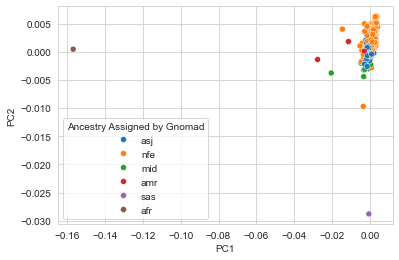

In [17]:
sns.scatterplot(v4_results_df, x="PC1", y="PC2", hue="Ancestry Assigned by Gnomad")
plt.show()

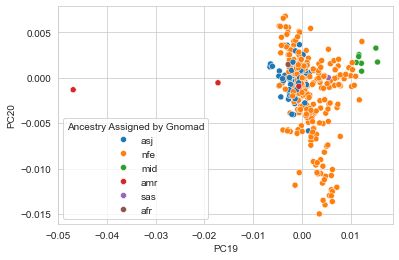

In [18]:
for i in range(1, 20):
    plt.clf()
    pc1 = "PC" + str(i)
    pc2 = "PC" + str(i + 1)
    filename = "../gnomad_pcs/" + pc1 + "_" + pc2 + ".png"
    sns.scatterplot(v4_results_df, x=pc1, y=pc2, hue="Ancestry Assigned by Gnomad")
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.savefig(filename)

In [20]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(v4_results_df.iloc[:, 0:-1])
embedding.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(334, 2)

In [22]:
embedding_df = pd.DataFrame(embedding, index=v4_results_df.index)
embedding_df.loc[:, "Ancestry Assigned by Gnomad"] = v4_results_df["Ancestry Assigned by Gnomad"]
embedding_df.head()

,0,1,Ancestry Assigned by Gnomad
s,,,
CW-170-S,-3.185082,1.810847,asj
CW-179-S,11.515563,7.039617,nfe
CW117-S,-2.929143,-0.083235,asj
CW12S,-3.461217,2.619804,asj
CW140-G,15.251091,2.561713,nfe


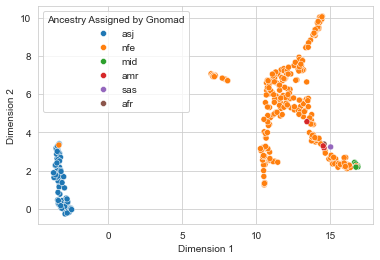

In [25]:
plt.clf()
sns.scatterplot(embedding_df, x=0, y=1, hue="Ancestry Assigned by Gnomad")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig("umap.png")
plt.show()

In [19]:
import plotly.express as px

fig = px.scatter(embedding_df, x=0, y=1,
                 hover_name=embedding_df.index, labels={0: "Dimension 1", 1: "Dimension 2"})
fig.show()

In [27]:
embedding_df["Ancestry Assigned by Gnomad"].to_csv("../results/gnomad_ancestries.tsv",
                                                   sep="\t")